In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import mygene

from rpy2.robjects import pandas2ri

pandas2ri.activate()

%load_ext rpy2.ipython

sc.settings.set_figure_params( dpi=80 )

/usr/local/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


# Format input files

In [25]:
# Load healthy individual 3-006 and Severe Dengue serotype 3 indivudal 1-026. These two patients have the most cells available.

def read_csv_sc( file_loc, md_loc, name=None ):
    dataset = pd.read_csv( file_loc )
    dataset_md = pd.read_csv( md_loc )
    dataset = dataset.rename( columns={ "Unnamed: 0" : "Accession" } )
    dataset = dataset.set_index( "Accession" )
    new_col_names = list()
    for i in dataset.columns:
        new_col_names.append( "_".join( i.split( "_" )[:3] ) )
    dataset.columns = new_col_names
    dataset = sc.AnnData( dataset.T )
    dataset.obs_names_make_unique()
    dataset.X = sp.sparse.csr_matrix( dataset.X )
    
    if name is None:
        dataset.obs["Sample"] = dataset_md["PatientID"].values
    else:
        dataset.obs["Sample"] = name
    dataset.obs["Tissue"] = dataset_md["Tissue"].values
    dataset.obs["Type"] = dataset_md["Type"].values
    dataset.obs["Sex"] = dataset_md["Sex"].values
    dataset.obs["Age"] = dataset_md["Age"].values
    dataset.obs["Disease_Status"] = dataset_md["Disease_Status"].values
    dataset.obs["Virus_Reads"] = dataset_md["VirusReads"].values 
    
    return dataset

patient_healthy = read_csv_sc( "/Users/natem/codeSandbox/tcr/0_data/Zanini/3-006.csv", "/Users/natem/codeSandbox/tcr/0_data/Zanini/3-006.metadata.csv", name="Healthy" )
patient_dengue = read_csv_sc( "/Users/natem/codeSandbox/tcr/0_data/Zanini/1-026.csv", "/Users/natem/codeSandbox/tcr/0_data/Zanini/1-026.metadata.csv", name="Dengue" )

mg = mygene.MyGeneInfo()
gene_df = mg.querymany( patient_healthy.var_names, scopes='ensembl.gene', fields="symbol", as_dataframe=True, returnall=True ) 
gene_df = gene_df["out"]
newlist = list()
for i in patient_healthy.var_names:
    query = str( gene_df.symbol[i] )
    if query == "nan":
        newlist.append( i )
    else:
        newlist.append( query )
patient_healthy.var_names = newlist
patient_dengue.var_names = newlist

patient_healthy.var_names_make_unique()
patient_dengue.var_names_make_unique()

patient_healthy = patient_healthy[:,~patient_healthy.var_names.str.contains( "__" )]
patient_dengue = patient_dengue[:,~patient_dengue.var_names.str.contains( "__" )]
patient_healthy = patient_healthy[:,:-1]
patient_dengue = patient_dengue[:,:-1]

patient_healthy.write_h5ad( "/Users/natem/Dropbox (Scripps Research)/Personal/Code/Python/CViSB_Workshop_TCell/data/healthy_pbmcs.hdf5")
patient_dengue.write_h5ad( "/Users/natem/Dropbox (Scripps Research)/Personal/Code/Python/CViSB_Workshop_TCell/data/dengue_pbmcs.hdf5")

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-25000...done.
querying 25001-26000...done.
querying 26001-27000...done.
querying 27001-28000...done.
querying 28001-29000...done.
querying 29001-30000...done.
querying 30001-31000...done.
querying 31001-32000...done.
querying 32001-33000...done.
querying 33001-34000...done.
querying 34001-35000...done.
queryin

/Users/natem/Dropbox (Scripps Research)/Personal/Code/Python/CViSB_Workshop_TCell/venv/lib/python3.7/site-packages/biothings_client/base.py:143: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df = json_normalize(obj)


2 input query terms found dup hits:
	[('ENSG00000229425', 2), ('ENSG00000249981', 2)]
4013 input query terms found no hit:
	['ENSG00000069712', 'ENSG00000116883', 'ENSG00000116957', 'ENSG00000122718', 'ENSG00000130201', 'ENS


# Dataset Selection
One benefit of the raise of single cell RNA-seq is the release of plentiful numbers of organism and cell type specific datasets. For this workshop, we'll be using two datasets provided by Zanini et al. from their paper [Virus-inclusive single-cell RNA sequencing reveals the molecular signature of progression to severe dengue](https://doi.org/10.1073/pnas.1813819115).

In brief, blood samples were collected from individuals presenting to a hospital in Columbia who met criteria for Dengue virus infection. Peripheral blood mononuclear cells were extracted and FACS was performed to enrich various immune cell types and to sort single cells in 384 well plates for a modified 5' RACE RNA-seq library preparation.

# Loading the data
The first thing to do is to load the data. In this case, it is provided as a TSV file where each column lists the feature (for our purposes this means gene) counts for a given cell (technically called observations and labeled as the cell barcode found in the sequencing data).

| Accession | Gene | Cell_1 | Cell_2 | Cell_3 |
| --------- | ---- | ------ | ------ | -------|
| ENSG00000252305.1 | SNORA74 | 1 | 2 | 3 |   
| ENSG00000154874.14 | CCDC144B | 1 | 2 | 3 |
| ENSG00000233528.4 | LINC00430 | 0 | 1 | 0 |    

Another common format you'll see is the sparse matrix format (often designated by .mtx files), which provides significant storage saving for data contains a lot of zeroes (like single cell expression data). This format is also tab seperated which each row contains the positive count for a single gene in a single cell. In this way only, only counts for genes which where observed in a cells sequnecing data are recorded, rather than the plethera of counts for genes not observed. 

In [2]:
#patient_dengue = sc.read_h5ad( "/Users/natem/Dropbox (Scripps Research)/Personal/Code/Python/CViSB_Workshop_TCell/data/dengue_pbmcs.hdf5" )
#patient_healthy = sc.read_h5ad( "/Users/natem/Dropbox (Scripps Research)/Personal/Code/Python/CViSB_Workshop_TCell/data/healthy_pbmcs.hdf5" )

#scdata = patient_dengue.concatenate( patient_healthy, join="outer" )

scdata = sc.read_h5ad( "/Users/natem/Dropbox (Scripps Research)/Personal/Code/Python/CViSB_Workshop_TCell/data/dengue_all.hdf5" )

Once loaded, the data is put into an AnnData format. It can be though of as the matrix displayed above, but with the ability for rows and columns to be annotated. 

The data itself can be access in the ".X" field. This field will change according to what preprocessing you perform on it, but the original counts can always be found in the ".raw" field. 

Individual cell annotations are found in the ".obs" field. We can add annotations like, what sample a cell belongs to, or what cell type it is. We can do the former now and add a label that each of the cells in the loaded dataset come from patient 1.

# Preprocessing

In [12]:
# Quickly remove some meaningless annotation
scdata = scdata[:,:-6]

scdata.var["mito"] = scdata.var_names.str.startswith( "MT-" )
scdata.var["ERCC"] = scdata.var_names.str.startswith( "ERCC-" )
sc.pp.calculate_qc_metrics( scdata, qc_vars=[ 'mito', 'ERCC' ], inplace=True )

print( "Columns added:" )
for i in scdata.obs_keys():
    print( i )

print( "scdata contains {} cells with counts for {} genes".format( scdata.n_obs, scdata.n_vars ) )

Trying to set attribute `.var` of view, copying.


Columns added:
Age
Disease_Status
PatientID
Sex
Type
VirusReads
n_genes_by_counts
log1p_n_genes_by_counts
total_counts
log1p_total_counts
pct_counts_in_top_50_genes
pct_counts_in_top_100_genes
pct_counts_in_top_200_genes
pct_counts_in_top_500_genes
total_counts_mito
log1p_total_counts_mito
pct_counts_mito
total_counts_ERCC
log1p_total_counts_ERCC
pct_counts_ERCC
scdata contains 12263 cells with counts for 60715 genes


So all together our datasets includes 3637 observations. While the majority of these are likely cells, this number is inflated by the presense of artifacts like dead cells, doublets, and barcode crosstalk. We will impose two limits on observations to filter these out.

The first of these is removing observations where greater than 15% of molecules align to genes from the mitocondrial genome. Expression of mitocondrial genes is associated with poor quality cells which have lost cytoplasmic RNA for one reason or another. Limit was selected so as to remove cells which lowly expressing cells with high mitochondrial counts.

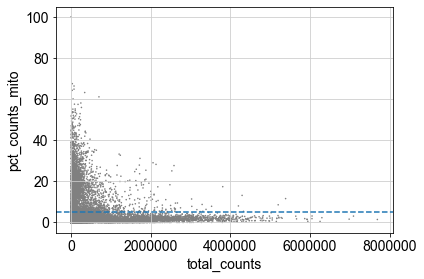

3466 observations (28.264%) will be removed with proposed mitochondrial limit


In [13]:
proposed_mt_limit = 5

ax = plt.subplot()
sc.pl.scatter( scdata, "total_counts", "pct_counts_mito", show=False, ax=ax )
plt.axhline( proposed_mt_limit, 0, 60000, linestyle="dashed" )
plt.show()

pct_removed = (scdata[scdata.obs["pct_counts_mito"] > proposed_mt_limit].n_obs / scdata.n_obs ) * 100

print( "{} observations ({:.3f}%) will be removed with proposed mitochondrial limit".format( scdata[scdata.obs["pct_counts_mito"] > proposed_mt_limit].n_obs, pct_removed ) )

The second filter will be a cell size filter. We will filter observations which contain either too little or too many genes counts or total counts as these would be indicative of dead cells and multiplets, respectively. 

As the number of unique gene counts per cell is normally distibuted, we should visually observation a gausian distribution in the number of molecules each observation contains. The upper and lower limits of cell size are selected where the distribution lacks normality.

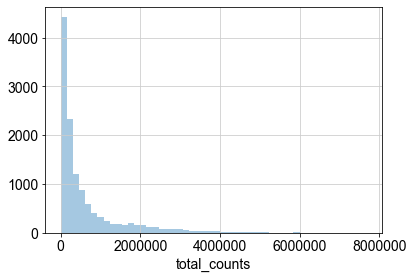

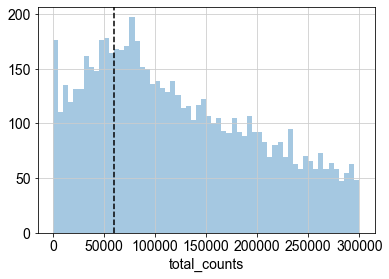

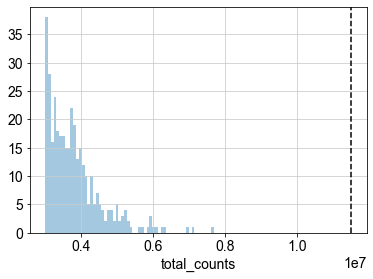

In [14]:
lower_counts = 60000
upper_counts = 11500000

#Thresholding decision: counts
sns.distplot( scdata.obs["total_counts"], kde=False )
plt.show()

sns.distplot( scdata.obs.loc[scdata.obs["total_counts"]<300000, "total_counts"], kde=False, bins=60 )
plt.axvline( lower_counts, 0, 100, linestyle="dashed", color="black" )
plt.show()

sns.distplot( scdata.obs.loc[scdata.obs["total_counts"]>3000000, "total_counts"], kde=False, bins=60 )
plt.axvline( upper_counts, 0, 20, linestyle="dashed", color="black" )
plt.show()

The histrogram of the number of counts per cells reveal a peak of cells with less than 150,000 counts. Given the distribution of counts, these are likely to be uninformative and likely arise as a a result of debris or dead cells in wells.

Likewise, the histogram shows a number of outlier observations which contain massive numbers of counts (>4,750,000 reads). We will remove these as well.

The same basic analysis is performed on unique gene counts as well. 

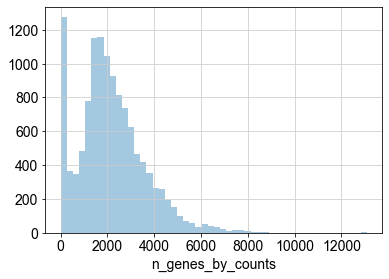

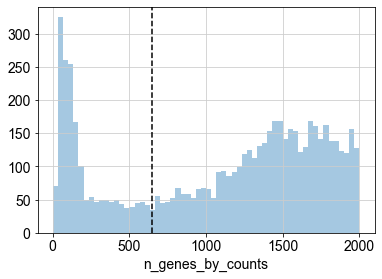

In [15]:
lower_genes = 650

scdata.obs["n_genes_by_counts"] = [row.count_nonzero() for row in scdata.X]

sns.distplot( scdata.obs["n_genes_by_counts"], kde=False )
plt.show()

sns.distplot( scdata.obs.loc[scdata.obs["n_genes_by_counts"] < 2000, "n_genes_by_counts"], kde=False, bins=60 )
plt.axvline( lower_genes, 0, 100, linestyle="dashed", color="black" )
plt.show()


In the histogram of unique gene counts per shows shows that a there is a large peak of cells expression a less than 500 genes. This peak is probably made up of either dead cells or wells that had only ambient RNA as input. 

In [16]:
print( "Total number of cells: {}".format( scdata.n_obs ) )

scdata = scdata[scdata.obs["pct_counts_mito"] < proposed_mt_limit]
print( "Number of observations after MT filter: {}".format( scdata.n_obs ) )

sc.pp.filter_cells( scdata, min_genes=lower_genes )
print( "Number of observations after min genes filter: {}".format( scdata.n_obs ) )

sc.pp.filter_cells( scdata, min_counts=lower_counts )
print( "Number of observations after min count filter: {}".format( scdata.n_obs ) )

sc.pp.filter_cells( scdata, max_counts=upper_counts )
print( "Number of observations after max count filter: {}".format( scdata.n_obs ) )

Total number of cells: 12263
Number of observations after MT filter: 8797


Trying to set attribute `.obs` of view, copying.


Number of observations after min genes filter: 7335
Number of observations after min count filter: 6931
Number of observations after max count filter: 6931


The last filter we apply will be on genes. We only want to included in downstream analyses genes which are expressed in at least 1% of cells. We'll also remove the counts for the ERCC spike-ins. These provide useful metrics for normalization but we don't want to imply anything biological from their values.

In [17]:
proposed_gene_limit = 0.02

print( "Total number of genes: {}".format( scdata.n_vars ) )

# Filters out 0 count genes. Really 20 count genes.
sc.pp.filter_genes( scdata, min_cells=scdata.n_obs * proposed_gene_limit )
print( "Number of genes after cell filter: {}".format( scdata.n_vars ) )

# Remove ERCC spike-ins
scdata = scdata[:,~scdata.var["ERCC"]]

Total number of genes: 60715
Number of genes after cell filter: 17203


# Normalization
We're going to use a pooled normalization approach which is implemented in the *scran* R package with the *computeSizeFactors* function to compute size factors for each cell.

To do this we'll quickly log normalize a copy of the data we have and use louvain clustering at a middling resolution to identify broad cell types. We'll then use these clusters when normalizing to account for cell type specific coverage differences.

In [18]:
scdata_copy = scdata.copy()
sc.pp.normalize_per_cell( scdata_copy, counts_per_cell_after=1e6, key_n_counts="total_counts" )
sc.pp.log1p( scdata_copy )
sc.pp.pca( scdata_copy, svd_solver="arpack", n_comps=15 )
sc.neighbors.neighbors( scdata_copy, n_pcs=15, use_rep="X_pca", random_state=42 )
sc.tl.louvain( scdata_copy, key_added="groups", resolution=0.5 )

input_groups = scdata_copy.obs["groups"]
data_mat = scdata.X.T.toarray()

In [19]:
%%R -i data_mat -i input_groups -o size_factors
library( scran )

size_factors = computeSumFactors( data_mat, clusters=input_groups, min.mean=0.1, positive=TRUE )

R[write to console]: Loading required package: BiocParallel

R[write to console]: Loading required package: SingleCellExperiment

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: GenomicRanges

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans

Trying to set attribute `.obs` of view, copying.


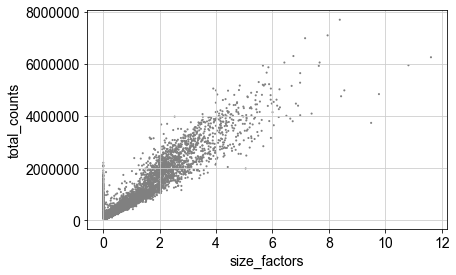

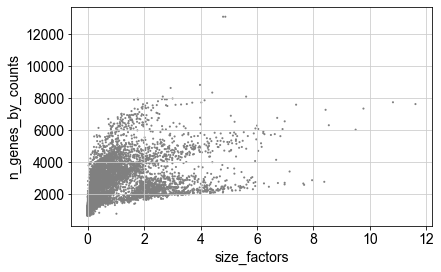

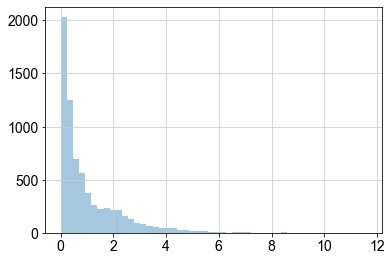

In [20]:
del scdata_copy

# Visualize the estimated size factors
scdata.obs["size_factors"] = size_factors

sc.pl.scatter( scdata, "size_factors", "total_counts" )
sc.pl.scatter( scdata, "size_factors", "n_genes_by_counts" )

sns.distplot( size_factors, bins=50, kde=False )
plt.show()

In [21]:
#Keep the count data in a counts layer
scdata.layers["counts"] = scdata.X.copy()

#Normalize adata 
scdata.X /= scdata.obs["size_factors"].values[:,None]
sc.pp.log1p( scdata )
scdata.X = sp.sparse.csr_matrix( scdata.X )

# Store the full data set in 'raw' as log-normalised data for statistical testing
scdata.raw = scdata

# Batch Correction

In [22]:
# ComBat batch correction
sc.pp.combat( scdata, key="PatientID" )

/usr/local/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py:338: RuntimeWarning: divide by zero encountered in true_divide
  change = max((abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max())


In [23]:
scdata.write_h5ad( "/Users/natem/Dropbox (Scripps Research)/Personal/Code/Python/CViSB_Workshop_TCell/data/dengue_processed.hdf5" )
#scdata = sc.read_h5ad( "/Users/natem/Dropbox (Scripps Research)/Personal/Code/Python/CViSB_Workshop_TCell/data/dengue_processed.hdf5" )

# Highly Variable Genes

Number of highly variable genes: 4000


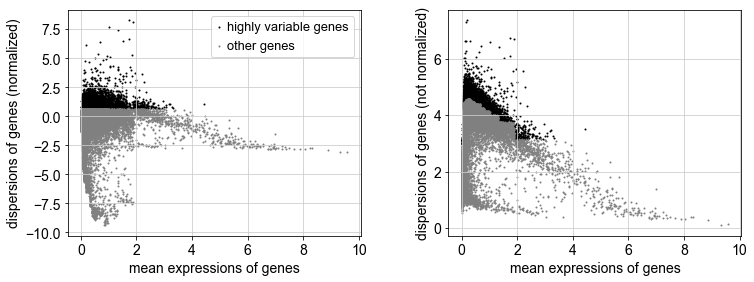

In [24]:
sc.pp.highly_variable_genes( scdata, flavor='cell_ranger', n_top_genes=4000 )
print( "Number of highly variable genes: {}".format( sum( scdata.var["highly_variable"] ) ) )

sc.pl.highly_variable_genes( scdata )

# Dimensionality Reduction
When analyzing single cell RNA-seq data, we aim to compare cells based on their expression across genes, i.e. to identify distinct transcriptomic profiles. However, expression of different genes may be correlated if they are affected by the same underlying biological process. In order to study these underlying biological processes, its necessary to compress the information from individual genes into a single dimension. Dimensionality reduction aims to reduce the number of dimensions needed to represent a dataset and presents a number of advantages:
* Reduces the computation load of downstream analyses.
* Reduced noise in dataset by averaging multiple correlated genes.
* Enables visualization of high dimensional dataset.


## Principal Component Analysis
The first technique we'll be using is Principal Component Analysis, or PCA. PCA reduces dimensionality by finding axes in the high dimensional data which capture the largest amount of variation. 

To perform PCA, an axis through the high dimensional data, also called a principal component (PC), is found which captures the greatest variance across cells. Next, another component is selected that is perpendicular to the first and captures the greatest remaining variance. This process can be repeated until a set number of principal components are found. 

Here we'll perform PCA on the normalized data and compute the first 50 principal components.

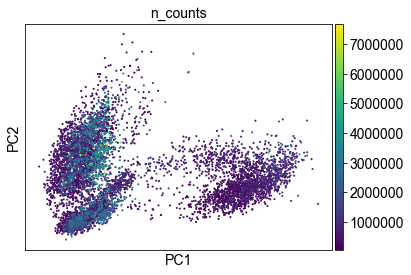

In [25]:
# Calculate the visualizations
sc.pp.pca( scdata, n_comps=50, use_highly_variable=True, random_state=42 )
sc.pl.pca( scdata, color="n_counts" )

In this plot we can already see distinct populations of cells, but, given that we've only plotted two principal components, its not that informative beyond that. One thing we can look at is the genes which contribute significantly to the first two principal components and ask whether they represent anything meaningful.

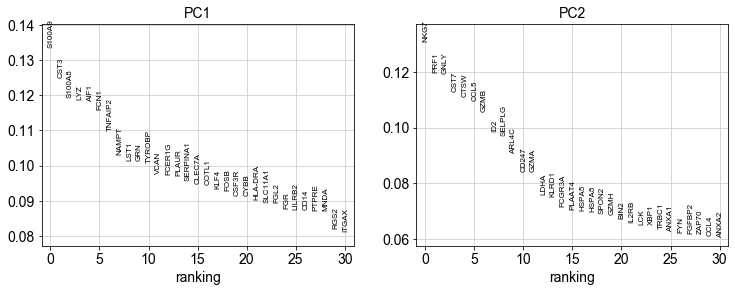

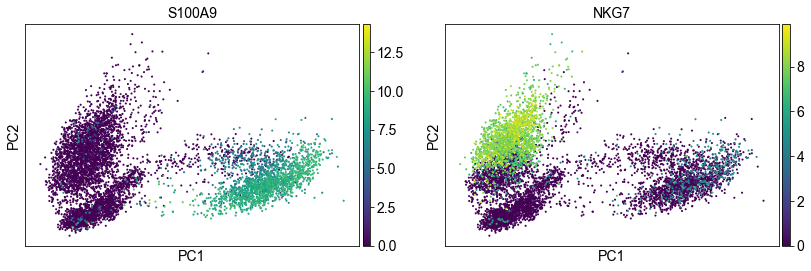

In [26]:
sc.pl.pca_loadings( scdata, components=[1,2], include_lowest=False )
sc.pl.pca( scdata, color=["S100A9", "NKG7"] )

We computed 50 principal components which represents a rather compact version of the dataset, though this is an arbitrary number. One question we can ask is how many principal components are neccessary to include for downstream analyses. Including more principal components means including more biological signal, but at the cost of more noise.

One heuristic we can use to select an appropriate number of principal components is an elbow plot, a plot which ranks principical components based on the percentage of variance they explain. We then include all principal components which lie above an elbow point on the plot where components above the point explain much more variance than the remaining components.

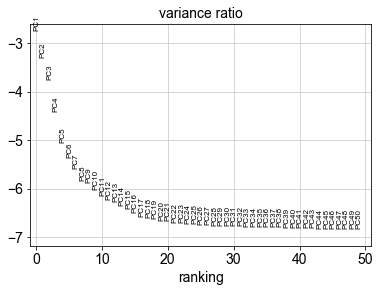

In [27]:
sc.pl.pca_variance_ratio( scdata, log=True, n_pcs=50 )

By looking at the graph we can see that we should probably include the top 17 principal components. Feel free to play around with the number of principal components to include and the effect it has on later analyses.

# Clustering
We'll now algorithmically define the populations of cells that we saw in the PCA plot with unsupervised clustering. 

The type of clustering we'll be performing is called graph-based clustering. First, we build a neighborhood graph where each node is a cell with edges connecting it to its nearest neighbors in terms of transcriptional profiles. Edges are then weighted based on the similarily to the neighboring cells. This graph is then used as input to a clustering algorithm which identifies clusters as cells which are more connected to eachother than to cells of other clusters.

In [32]:
sc.pp.neighbors( scdata, n_pcs=17, random_state=42 )

We next need to decide which clustering algorithm to use. There are essentially two commonly used algorithms, Louvain and Leiden, which are commonly used. Both iteratively group cells together and attempt to maximize the difference between the number of edges in a cluster and the number of edges expected to arise due to chance (modularity). We'll perform both and compare results to determine which is better for this dataset.

One other factor we need to consider is the resolution parameter which both algorithms require. This represents the granularity of the resulting clusters. Higher values generate a greater number of clusters and typically values of between 0.4 and 1.5 are seen depending on the size of the dataset. For our purposes, and since we only need to cluster broad cell types now, a resolution of 0.5 will be used.

In [33]:
sc.tl.leiden( scdata, resolution=0.5, key_added="leiden_r0.5", random_state=42 )
sc.tl.louvain( scdata, resolution=0.5, key_added="louvain_r0.5", random_state=42 )

To visualize the clustering results, we apply further dimensional reduction using a non-linear, unlike PCA, technique called UMAP. Similar to t-SNE, the UMAP algorithm attempts to aaccurately convey the local and global distances between cells' transcriptomic profiles in two dimensions.

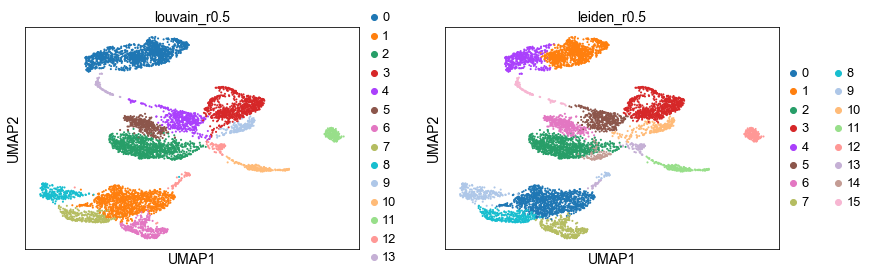

In [34]:
sc.tl.umap( scdata, random_state=42 )
sc.pl.umap( scdata, color=["louvain_r0.5", "leiden_r0.5"] )

The clustering results are fairly comparable but we can see that Leiden algorithm produces clusters which are more similar to what we would identify by eye. Look at the cresent shaped cluster in the upper center of the graph. Visually this looks like one cluster, while louvain splits it up the cells, some of which it classifies in far away clusters. 

For the rest of this tutorial we'll be using the leiden algorithm, but feel free to compare the results with the louvain algorithm.

# T Cell Selection
To determine which of the clusters we just calculated correspond to T cells, we're going to look at the expression of canonical T cell markers, CD3 and the T cell receptor alpha constant chain, in these clusters.

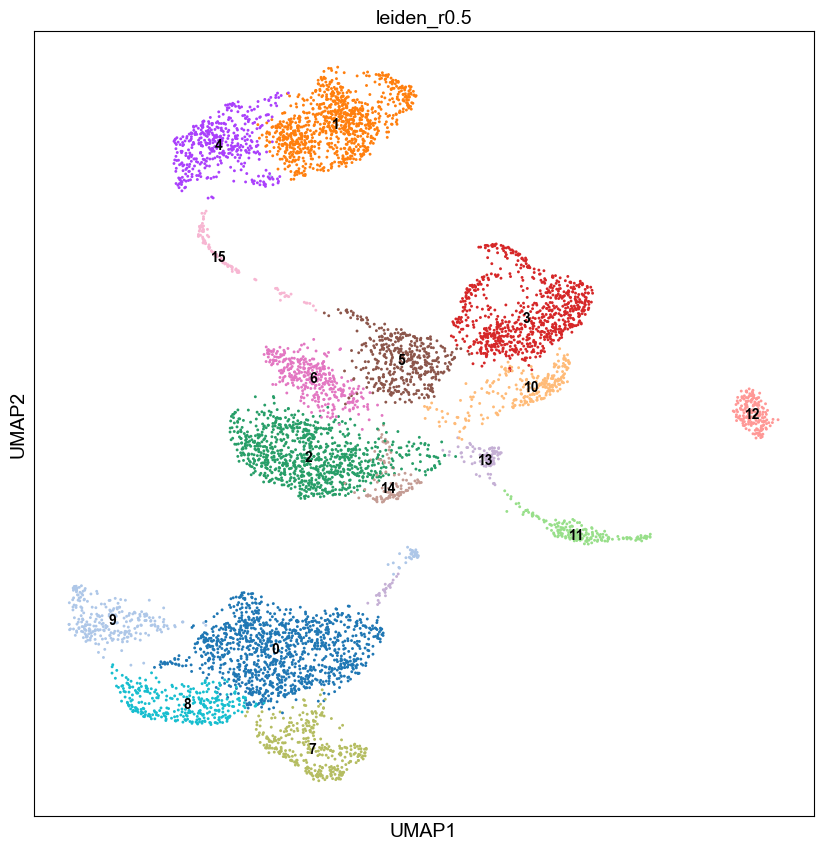

In [39]:
plt.figure( dpi=100, figsize=(10,10) )
ax = plt.subplot()
sc.pl.umap( scdata, color="leiden_r0.5", ax=ax, legend_loc="on data" )
plt.show()

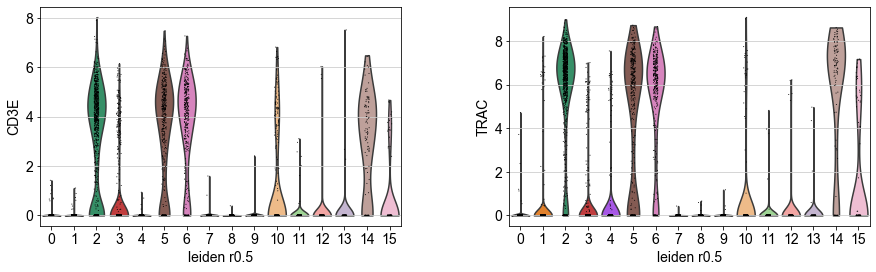

In [49]:
sc.pl.violin( scdata, ["CD3E", "TRAC"], groupby="leiden_r0.5" )

By using the UMAP embeddings and the expression of canonical T cell markers, we can observe that T cells are likely found in clusters 2, 3, 5, 6, 10, and 14 

Cluster  13, and 15 are also a candidate for containing T cells, but we won't include them in the T cell group. Cluster 15 expresses CD3 and TRAC, but that likely is a result of multiplets. The other puntative T cell clusters group closely together in the UMAP embedding while cluster 15 is intermediate to a larger non-T cell cluster and the T cells. Cluster 13 lies close to the T cell cluster, but has neither expression of CD3 nor TRAC.

Furthermore, it is likely that all clusters contain some percentage of multiplet cells and cells which are incorrectly clusters. The next step in our analysis will be to identify cells in our putative T cell clusters that fit either of these cases using a method developed by [Szabo et al. 2019](https://doi.org/10.1038/s41467-019-12464-3). In brief, we generate a blacklist of genes that are overexpressed in non-T cell cluster and use those to remove contaminating cells in the T cell cluster.

In [50]:
# Merge and rename T cell cluster
scdata.obs["cluster"] = (scdata.obs["leiden_r0.5"]
                         .map(lambda x: {"2": "T Cell", "3" : "T Cell", "5" : "T Cell", "6" : "T Cell", "10" : "T Cell", "14" : "T Cell"}.get(x, x) )
                         .astype("category") )
scdata.obs["cluster"].value_counts()

T Cell    2851
0         1158
1          957
4          434
7          332
8          319
9          295
11         188
12         187
13         112
15          98
Name: cluster, dtype: int64

## Generate Blacklist
To generate the blacklist of genes, we conduct differential expression analysis pairwise between the T cell cluster and each non-T cell cluster. We then add all genes have an adjusted p-value of greater than 0.001 and greater than 5-fold enrichment in non-T cell clusters.

In [51]:
# Perform differential expression analysis, comparing each cluster with the putative T cell cluster.
sc.tl.rank_genes_groups( scdata, groupby="cluster", groups=[0,1,4,7,8,9,11,12,13,15], reference="T Cell", method="wilcoxon", use_raw=False, n_genes=-1 )

# Add differentially expressed genes for each cluster to the blacklist.
blacklist = list()
for i in ["0","1","4","7","8","9","11","12","13","15"]:
    blacklist_genes = (scdata.uns["rank_genes_groups"]["logfoldchanges"][i] > 5 ) & ( scdata.uns["rank_genes_groups"]["pvals_adj"][i] < 0.001 )
    blacklist.extend( scdata.uns["rank_genes_groups"]["names"][i][blacklist_genes] )
blacklist = np.unique( blacklist )
print( "{} genes added to the blacklist".format( len( blacklist ) ) )

/usr/local/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:362: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


1488 genes added to the blacklist


## Generate Whitelist 
We also generate a whitelist of genes which are positively enriched in any T cell cluster. In this way we avoid inclusion of genes which are differentially expressed in a limited number of T cells. 

We perform differential expression analysis again, but this time comparing all putative T cell clusters to all other identified clusters. We use the same requirements as noted for generating the gene blacklist.

In [52]:
# Perform differential expression analysis, comparing each of the T cell clusters to the rest of the clusters.
sc.tl.rank_genes_groups( scdata, groupby="leiden_r0.5", groups=[2,3,5,6,10,14], reference="rest", method="wilcoxon", use_raw=False, n_genes=-1 )

# Combine differentially expressed genes
whitelist = list()
for i in ["2", "3", "5", "6", "10", "14"]:
    whitelist_genes = (scdata.uns["rank_genes_groups"]["logfoldchanges"][i] > 5 ) & ( scdata.uns["rank_genes_groups"]["pvals_adj"][i] < 0.001 )
    whitelist.extend( scdata.uns["rank_genes_groups"]["names"][i][whitelist_genes] )
whitelist = np.unique( whitelist )

print( "{} genes added to the whitelist".format( len( whitelist ) ) )
print( whitelist )

/usr/local/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


61 genes added to the whitelist
['A2M' 'ADGRG1' 'AKR1C3' 'CCL4' 'CCL5' 'CCR7' 'CD247' 'CD3D' 'CD3G' 'CD8A'
 'CLIC3' 'CST7' 'CTSW' 'CX3CR1' 'DUSP2' 'FCER1G' 'FCGR3A' 'FCRL6' 'FGFBP2'
 'GNLY' 'GZMA' 'GZMB' 'GZMH' 'GZMK' 'HOPX' 'IFITM1' 'IGFBP7' 'IL2RB'
 'IL32' 'IL7R' 'KIR2DS4' 'KLRB1' 'KLRC1' 'KLRD1' 'KLRF1' 'KLRG1' 'LDHB'
 'LEF1' 'MAL' 'NCR1' 'NCR3' 'NKG7' 'PRF1' 'PRKCQ-AS1' 'S1PR5' 'SH2D1B'
 'SLC4A10' 'SPON2' 'TARP' 'TBX21' 'TCF7' 'TRAC' 'TRAV1-2' 'TRBC1' 'TRBC2'
 'TRDC' 'TRGC2' 'TTC38' 'TYROBP' 'XCL2' 'ZNF683']


In [53]:
blacklist = [x for x in blacklist if x not in whitelist]
print( "{} genes ultimately in blacklist".format( len( blacklist ) ) )

1485 genes ultimately in blacklist


Ultimately, the whitelist shared 3 genes with the blacklist. This may not make much of a difference, but its still good practice to check that you're not removing things like that.

## Remove Non-T cells
We'll now use the blacklist to remove cells which have been erroneously included in T cell clusters. We will then remove cells which express the blacklist genes above a certain threshold.

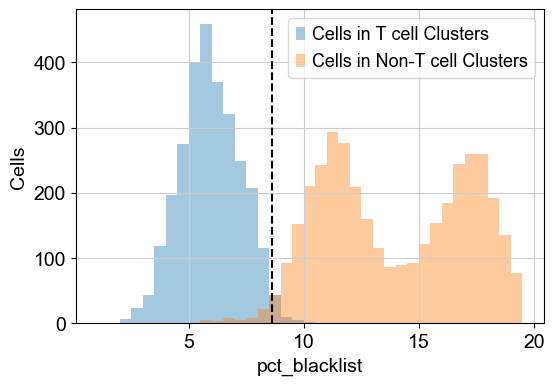

Threshold determined to be: 8.61%


In [60]:
# Calculate the percentage of normalized counts for blacklisted genes detected for each cell.
scdata.var["blacklist"] = scdata.var_names.isin( blacklist )
temp = sc.pp.calculate_qc_metrics( scdata, qc_vars=["blacklist"] )
scdata.obs["pct_blacklist"] = temp[0]["pct_counts_blacklist"]

# Calculate mean and absolute deviation of expression of blacklisted genes in T cell cluster.
mean_pct_blacklist = scdata.obs.loc[(scdata.obs["cluster"]=="T Cell"), "pct_blacklist"].mean()
mad_pct_blacklist = scdata.obs.loc[(scdata.obs["cluster"]=="T Cell"), "pct_blacklist"].mad()

# Plot distribution of blacklisted gene expression
plt.figure( dpi=100 )
ax = plt.subplot()
sns.distplot( scdata.obs.loc[(scdata.obs["cluster"]=="T Cell"), "pct_blacklist"], bins=np.arange(1,20,0.5), label="Cells in T cell Clusters", kde=False )
sns.distplot( scdata.obs.loc[(scdata.obs["cluster"]!="T Cell"), "pct_blacklist"], bins=np.arange(1,20,0.5), label="Cells in Non-T cell Clusters", kde=False )
plt.axvline( mean_pct_blacklist + 2.5*mad_pct_blacklist, 0, 20, linestyle="dashed", color="black" )
plt.ylabel( "Cells" )
plt.legend()
plt.show()

blacklist_threshold = mean_pct_blacklist + 2.5*mad_pct_blacklist
print( "Threshold determined to be: {:.2f}%".format( blacklist_threshold ) )

Interestingly, and likely because of the high per-cell sequencing depth of this dataset, we see a certain amount of expression of the blacklisted genes in every cell. However, we can exploit the bi/tri-modal nature of the distribution of expression of the blacklisted genes to adequately filter T cells. Szabo et al ascribes the expression of blacklisted genes in the T cell cluster to PCR recombination, where a molecule originating from one cell receives the cell-identifying barcode of a different cell at an intermediate point in PCR. 

We can see that the T cell distribution appears to be normally distributed with a slight positive skew. A simple threshold would then be anywhere from 2-3 mean absolute deviations above the mean of the T cell distribution. We use the mean absolute deviation here instead of the standard deviation because its less sensitive to outliers which this dataset doesn't have but others typically do. We consider any cell with expression of the blacklisted genes above this threshold and any cell in a non-T cell cluster to be a non-T cell and remove them from further analysis (Plot the dataset and color by cells below this threshold to see why we don't include all cells with expression of blacklisted genes below this threshold).

In [61]:
T_before = scdata.obs["cluster"].value_counts()["T Cell"]
scdata = scdata[(scdata.obs["cluster"]=="T Cell") & (scdata.obs["pct_blacklist"]<blacklist_threshold)]
T_after = scdata.n_obs

print( "Number of cells removed by blacklist gene filter: {}".format( T_before - T_after ) )
print( "Number of T cells identified: {}".format( T_after ) )

Number of cells removed by blacklist gene filter: 52
Number of T cells identified: 2799


# T Cell Clustering
Now that T cells have been identified, we'll cluster again to determine what populations we can identify. We will use the same procedure as before, calculating highly variable genes, dimensionality reduction, followed by clustering.

Trying to set attribute `.var` of view, copying.


Number of highly variable genes: 2000


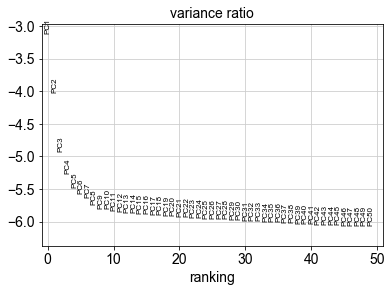

In [62]:
# Identify highly variable genes
sc.pp.highly_variable_genes( scdata, flavor='cell_ranger', n_top_genes=2000 )
print( "Number of highly variable genes: {}".format( sum( scdata.var["highly_variable"] ) ) )

# Dimensionality reduction using PCA
sc.pp.pca( scdata, n_comps=50, use_highly_variable=True, random_state=42 )
sc.pl.pca_variance_ratio( scdata, log=True, n_pcs=50 )

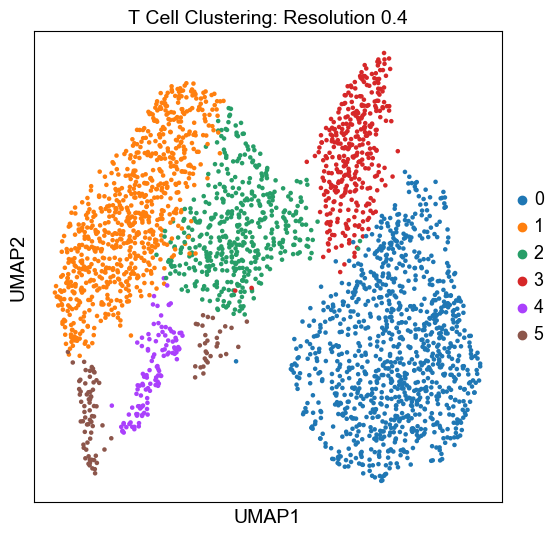

In [65]:
# Build neighborhood graph
sc.pp.neighbors( scdata, n_pcs=10, random_state=42 )

# Cluster at a middling resolution
sc.tl.leiden( scdata, resolution=0.4, key_added="subset", random_state=42 )

# Calculate UMAP embedding
sc.tl.umap( scdata, random_state=42 )

# 
plt.figure( dpi=100, figsize=(6,6) )
ax = plt.subplot()
sc.pl.umap( scdata, color=["subset"], ax=ax, title="T Cell Clustering: Resolution 0.4" )
plt.show()

# T Cell Subset Characterization

## CD4 vs. CD8

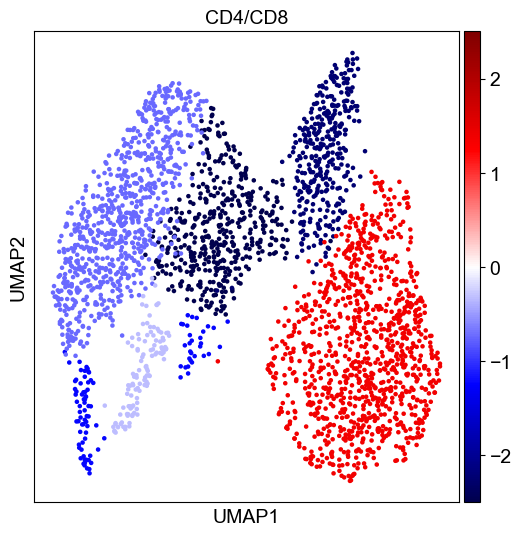

In [73]:
# Calculate the log ratio of CD4 to CD8 expression
scdata.obs["CD4"] = scdata[:,"CD4"].X
scdata.obs["CD8"] = scdata[:,"CD8A"].X
scdata.obs["CD4/CD8"] = scdata.obs.groupby("subset")["CD4"].transform( "mean" ) - scdata.obs.groupby( "subset" )["CD8"].transform( "mean" )
scdata.obs = scdata.obs.drop( columns=["CD4", "CD8"] )

plt.figure( dpi=100, figsize=(6,6) )
ax = plt.subplot()
sc.pl.umap( scdata, color=["CD4/CD8"], ax=ax, vmin=-2.5, vmax=2.5, color_map="seismic" )
plt.show()

Cluster 0 are likely CD4-positive T cells, while the rest are firmly CD8-positive T cells.

## Subset Identification
To give sense to the identified subsets, besides merely CD4 and CD8 expression, we need to determine the genes whose expressions differentiates the clusters. We can then use these "marker" genes to assign clusters to canonical cell types and determine functional differences between clusters.

Marker genes are identified by their differential expression between clusters. Genes which are more strongly differentially expression are more likely to cause seperation between clusters of cells. To quantify differential expression we can use any number of statistical tests (t-test, wilcoxon test, linear regression) to make pairwise comparisons between clusters. For our purposes, we'll use the Wilcoxon rank sum test which is comparable to more complex methods. For a thorough comparison of differential expression methods, check out [Soneson and Robinson 2018](https://doi.org/10.1038/nmeth.4612).

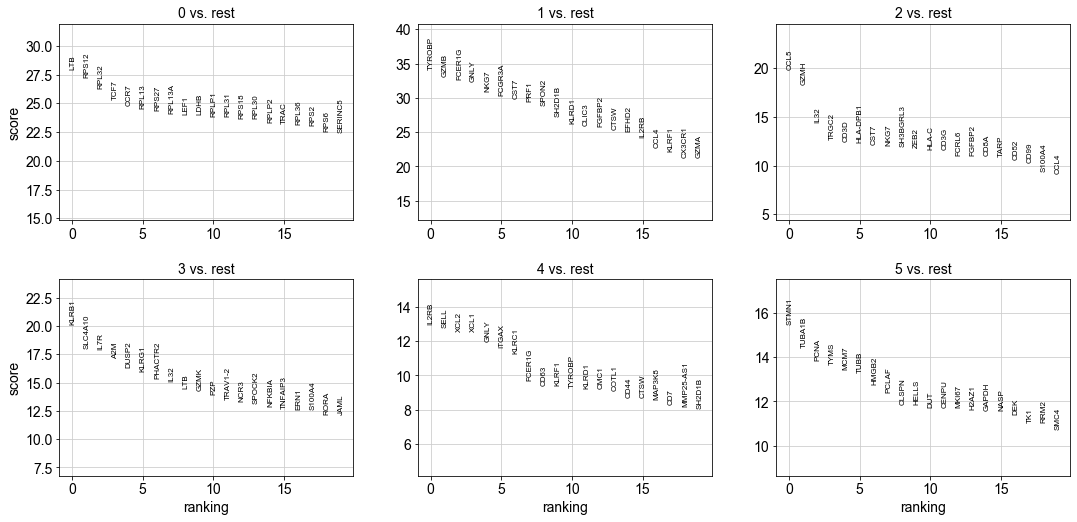

,0,1,2,3,4,5
0,LTB,TYROBP,CCL5,KLRB1,IL2RB,STMN1
1,RPS12,GZMB,GZMH,SLC4A10,SELL,TUBA1B
2,RPL32,FCER1G,IL32,IL7R,XCL2,PCNA
3,TCF7,GNLY,TRGC2,A2M,XCL1,TYMS
4,CCR7,NKG7,CD3D,DUSP2,GNLY,MCM7
5,RPL13,FCGR3A,HLA-DPB1,KLRG1,ITGAX,TUBB
6,RPS27,CST7,CST7,PHACTR2,KLRC1,HMGB2
7,RPL13A,PRF1,NKG7,IL32,FCER1G,PCLAF
8,LEF1,SPON2,SH3BGRL3,LTB,CD63,CLSPN
9,LDHB,SH2D1B,ZEB2,GZMK,KLRF1,HELLS


In [82]:
sc.tl.rank_genes_groups( scdata, groupby="subset", method="wilcoxon", use_raw=True, n_genes=100 )
sc.pl.rank_genes_groups( scdata, n_genes=20, ncols=3, sharey=False )

marker_genes = pd.DataFrame( scdata.uns["rank_genes_groups"]["names"] )
marker_genes.head(10)

Cluster 0 - Total CD4+  
Cluster 1 - Exhausted or innate-like CD8+ (Terminally differentiated effector cells [TEMRA])  
Cluster 2 - Effector memory CD8+  
Cluster 3 - Effector or recently activated CD8+  
Cluster 4 - Effector Cytotoxic  
Cluster 5 - Proliferating cells  
  
The clustering we've performed thus far has only identified a single CD4+ despite the prescence of many canonical subtypes. We can subcluster the CD4+ cluster to determine if we can identify known memory and effector subsets. 

Subclustering is typically performed at a lower resolution than on the entire dataset diven that clustering is more sensitive when performed on asmall subset of the data.

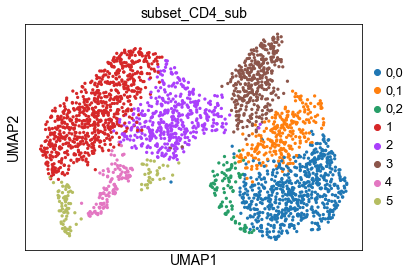

<Figure size 1200x800 with 0 Axes>

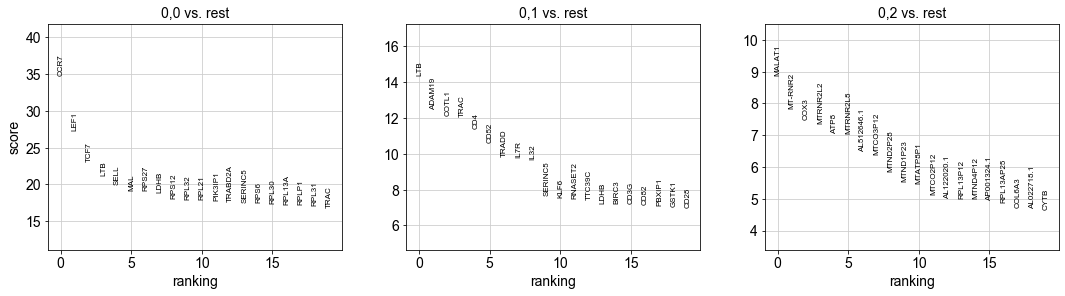

In [135]:
sc.tl.leiden( scdata, restrict_to=( "subset", ["0"] ), resolution=0.2, key_added="subset_CD4_sub" )

sc.pl.umap( scdata, color="subset_CD4_sub" )

sc.tl.rank_genes_groups( scdata, groupby="subset_CD4_sub", key_added="rank_CD4_sub" )

plt.figure( dpi=200 )
sc.pl.rank_genes_groups( scdata, key="rank_CD4_sub", groups=["0,0", "0,1", "0,2"], ncols=3, sharey=False, show=False )
plt.show()

In [ ]:
0,0 - Resting CD4+
0,1 - Activated CD4+

# T Cell Functional Comparison

<Figure size 600x400 with 0 Axes>

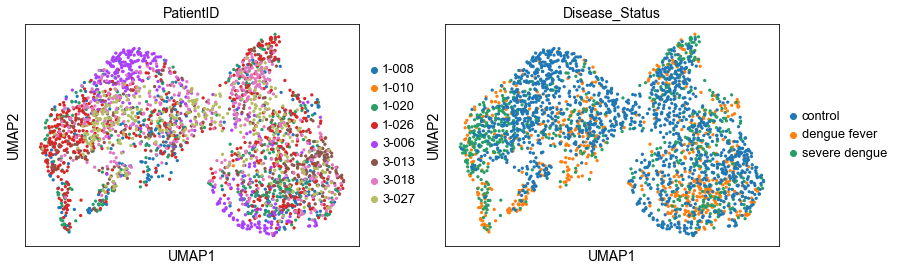

In [111]:
plt.figure( dpi=100 )
sc.pl.umap( scdata, color=["PatientID", "Disease_Status"])
plt.show()

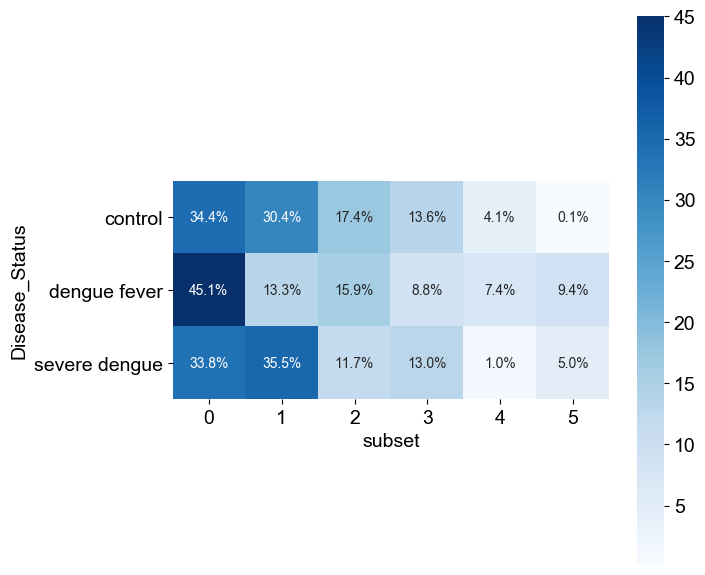

In [131]:
cells_patient = pd.crosstab( scdata.obs["Disease_Status"], scdata.obs["subset"] ).apply( lambda r: np.round( r/r.sum()*100, 2 ), axis=1 )
plt.figure( dpi=100, figsize=(7,7) )
ax=plt.subplot()
sns.heatmap( cells_patient, square=True, annot=True, fmt=".1f", cmap="Blues", ax=ax )
for t in ax.texts: t.set_text(t.get_text() + "%")
plt.show()

<Figure size 1200x800 with 0 Axes>

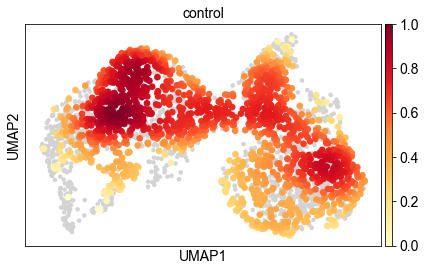

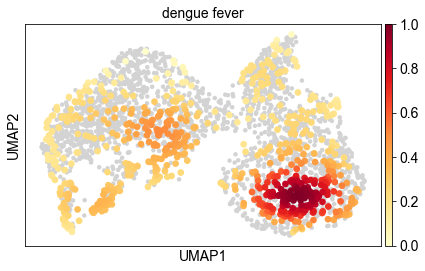

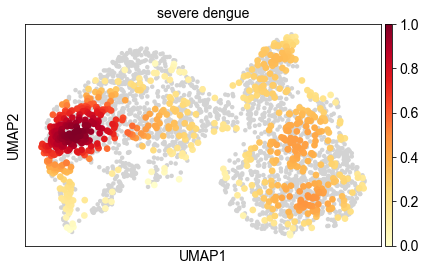

In [121]:
sc.tl.embedding_density( scdata, groupby="Disease_Status", key_added="umap_density_disease_status" )
plt.figure( dpi=200 )
sc.pl.embedding_density( scdata, key="umap_density_disease_status", group="control",  )
sc.pl.embedding_density( scdata, key="umap_density_disease_status", group="dengue fever" )
sc.pl.embedding_density( scdata, key="umap_density_disease_status", group="severe dengue" )